# Queue Simulation Analysis - Clean Data & Visualization

This notebook provides clean data analysis of 4 software development workflow scenarios:
1. **Traditional PR** - Individual developers with PR review process
2. **AI-Enhanced PR** - AI-assisted developers with PR review
3. **Pair Programming** - Traditional pairs with trunk-based development
4. **AI-Enhanced Pairs** - AI-assisted pairs with trunk-based development

Focus: Clean data output for analysis and visualization.

In [1]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from enum import Enum
from typing import List, Dict, Optional
import random

# Set random seed for reproducible results
random.seed(42)
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [ ]:
# Core Data Classes (CORRECTED to match Planning Document)

class TicketState(Enum):
    BACKLOG = "backlog"
    IN_PROGRESS = "in_progress"
    IN_REVIEW = "in_review"
    COMPLETED = "completed"

@dataclass
class Ticket:
    id: int
    state: TicketState = TicketState.BACKLOG
    started_at: Optional[datetime] = None
    completed_at: Optional[datetime] = None
    coding_start_time: Optional[datetime] = None
    coding_end_time: Optional[datetime] = None
    pr_created_at: Optional[datetime] = None
    pr_reviewed_at: Optional[datetime] = None
    rework_cycles: int = 0
    
    @property
    def lead_time(self) -> timedelta:
        if self.started_at and self.completed_at:
            return self.completed_at - self.started_at
        return timedelta(0)

@dataclass
class Developer:
    id: int
    name: str
    is_ai_enhanced: bool = False
    is_pair: bool = False
    
    @property
    def coding_speed_multiplier(self) -> float:
        # AI provides 30% speedup: 1 day becomes 0.7 days, so multiplier = 1/0.7 = 1.43
        return 1.43 if self.is_ai_enhanced else 1.0
    
    @property
    def defect_rate(self) -> float:
        """CORRECTED: AI has NO impact on defect rates per planning doc"""
        if self.is_pair:
            return 0.18  # 40% fewer defects than 30% baseline (30% * 0.6 = 18%)
        else:
            return 0.30  # 30% baseline for both traditional and AI developers

@dataclass  
class PRReview:
    ticket_id: int
    created_at: datetime
    reviewer_assigned: Optional[int] = None
    review_started_at: Optional[datetime] = None
    review_completed_at: Optional[datetime] = None
    requires_rework: bool = False

class DefectManager:
    def check_for_defects(self, developer: Developer) -> bool:
        return random.random() < developer.defect_rate
    
    def calculate_rework_time(self, original_time: timedelta, developer: Developer) -> timedelta:
        # 25% of original time for rework
        return original_time * 0.25

class PRReviewQueue:
    """Models the PR review queue with daily capacity constraints"""
    
    def __init__(self):
        self.daily_review_capacity_hours = 2.0  # 2 hours total per day
        self.review_time_per_pr_minutes = 20    # ~15-20 minutes per PR
        self.max_prs_per_day = int((self.daily_review_capacity_hours * 60) / self.review_time_per_pr_minutes)
        self.pending_reviews: List[PRReview] = []
        self.daily_reviews_completed = 0
        self.current_day = 0
        
    def advance_day(self):
        """Reset daily counters for new day"""
        self.current_day += 1
        self.daily_reviews_completed = 0
        
    def add_pr_for_review(self, pr: PRReview) -> bool:
        """Add PR to review queue"""
        self.pending_reviews.append(pr)
        return True
        
    def process_daily_reviews(self) -> List[PRReview]:
        """Process PRs within daily capacity limit"""
        completed_today = []
        
        while (self.daily_reviews_completed < self.max_prs_per_day and 
               self.pending_reviews):
            pr = self.pending_reviews.pop(0)
            
            # Simulate review process
            pr.review_started_at = datetime.now()
            pr.review_completed_at = pr.review_started_at + timedelta(minutes=self.review_time_per_pr_minutes)
            
            # Determine if rework is needed (based on defect rate)
            pr.requires_rework = random.random() < 0.30  # 30% need rework
            
            completed_today.append(pr)
            self.daily_reviews_completed += 1
            
        return completed_today
        
    def get_queue_length(self) -> int:
        return len(self.pending_reviews)

print("✅ CORRECTED Core classes defined to match planning document")
print("🔧 Fixed: AI defect rates, PR queue system, review capacity constraints")

✅ Core classes defined


In [3]:
# Clean Simulation Classes (Data-Focused)

class CleanSimulation:
    """Base simulation class focused on data generation"""
    
    def __init__(self, scenario_name: str):
        self.scenario_name = scenario_name
        self.completed_tickets = []
        self.defect_manager = DefectManager()
        self.daily_data = []  # Track daily metrics
        self.current_day = 0
    
    def advance_day(self):
        self.current_day += 1
    
    def record_daily_metrics(self, tickets_completed_today: int):
        """Record metrics for the current day"""
        total_completed = len(self.completed_tickets)
        avg_lead_time = 0
        if total_completed > 0:
            avg_lead_time = sum(t.lead_time.total_seconds() / 3600 for t in self.completed_tickets) / total_completed
        
        self.daily_data.append({
            'day': self.current_day,
            'scenario': self.scenario_name,
            'tickets_completed_today': tickets_completed_today,
            'total_tickets_completed': total_completed,
            'cumulative_throughput': total_completed / self.current_day if self.current_day > 0 else 0,
            'avg_lead_time_hours': round(avg_lead_time, 2),
            'total_rework_cycles': sum(t.rework_cycles for t in self.completed_tickets)
        })
    
    def get_summary_metrics(self) -> Dict:
        """Get final summary metrics"""
        total_tickets = len(self.completed_tickets)
        if total_tickets > 0:
            avg_lead_time = sum(t.lead_time.total_seconds() / 3600 for t in self.completed_tickets) / total_tickets
            tickets_per_day = total_tickets / self.current_day if self.current_day > 0 else 0
            total_rework = sum(t.rework_cycles for t in self.completed_tickets)
        else:
            avg_lead_time = 0
            tickets_per_day = 0
            total_rework = 0
        
        return {
            'scenario': self.scenario_name,
            'total_tickets': total_tickets,
            'avg_lead_time_hours': round(avg_lead_time, 2),
            'tickets_per_day': round(tickets_per_day, 2),
            'total_rework_cycles': total_rework,
            'simulation_days': self.current_day
        }

print("✅ Clean simulation base class ready")

✅ Clean simulation base class ready


In [ ]:
# Traditional PR Scenario (CORRECTED to match Planning Document)

class TraditionalPRScenario(CleanSimulation):
    def __init__(self):
        super().__init__("Traditional PR")
        self.pr_queue = PRReviewQueue()
        self.active_tickets = {}  # Track tickets in progress
        
    def run_simulation(self, days: int = 30) -> Dict:
        """Run traditional PR simulation with proper queue modeling"""
        
        # Create 8 traditional developers
        developers = [Developer(i+1, f"Dev{i+1}", is_ai_enhanced=False) for i in range(8)]
        
        for day in range(days):
            self.advance_day()
            self.pr_queue.advance_day()
            
            print(f"Day {self.current_day}: Starting with {self.pr_queue.get_queue_length()} PRs in queue")
            
            # Step 1: Process PR reviews (daily capacity constraint)
            completed_reviews = self.pr_queue.process_daily_reviews()
            
            # Step 2: Handle review results and rework
            for pr in completed_reviews:
                if pr.ticket_id in self.active_tickets:
                    ticket = self.active_tickets[pr.ticket_id]
                    
                    if pr.requires_rework:
                        # Developer must stop current work and fix issues
                        print(f"  PR {pr.ticket_id} needs rework")
                        ticket.rework_cycles += 1
                        
                        # Find the developer who authored this ticket
                        dev = developers[(pr.ticket_id - 1) % len(developers)]
                        rework_time = self.defect_manager.calculate_rework_time(timedelta(hours=8), dev)
                        
                        # Rework completed, create new PR
                        new_pr = PRReview(
                            ticket_id=ticket.id,
                            created_at=datetime.now()
                        )
                        self.pr_queue.add_pr_for_review(new_pr)
                    else:
                        # PR approved - ticket completed
                        ticket.completed_at = pr.review_completed_at
                        ticket.state = TicketState.COMPLETED
                        self.completed_tickets.append(ticket)
                        del self.active_tickets[ticket.id]
                        print(f"  ✅ Ticket {ticket.id} completed")
            
            # Step 3: Developers work on new tickets (after handling any rework)
            tickets_today = 0
            for dev_idx, dev in enumerate(developers):
                # Start new ticket if developer is available
                ticket = Ticket(id=len(self.completed_tickets) + len(self.active_tickets) + 1)
                ticket.started_at = datetime.now()
                ticket.state = TicketState.IN_PROGRESS
                
                # Coding time (1 day = 8 hours, affected by AI speedup)
                coding_time = timedelta(hours=8) / dev.coding_speed_multiplier
                ticket.coding_start_time = ticket.started_at
                ticket.coding_end_time = ticket.started_at + coding_time
                
                # Check for defects during initial coding
                if self.defect_manager.check_for_defects(dev):
                    # Add rework time to initial coding
                    rework_time = self.defect_manager.calculate_rework_time(timedelta(hours=8), dev)
                    ticket.coding_end_time += rework_time
                    ticket.rework_cycles += 1
                
                # Create PR at end of coding
                pr = PRReview(
                    ticket_id=ticket.id,
                    created_at=ticket.coding_end_time
                )
                ticket.pr_created_at = pr.created_at
                
                # Add to PR review queue
                self.pr_queue.add_pr_for_review(pr)
                self.active_tickets[ticket.id] = ticket
                
                print(f"  Dev{dev.id} completed coding ticket {ticket.id}, added to PR queue")
                tickets_today += 1
            
            print(f"  End of day: {self.pr_queue.get_queue_length()} PRs waiting, {len(self.active_tickets)} tickets in progress")
            self.record_daily_metrics(len(completed_reviews))  # Count completed tickets, not started
        
        # Handle any remaining tickets in queue
        while self.pr_queue.get_queue_length() > 0:
            self.advance_day()
            self.pr_queue.advance_day()
            completed_reviews = self.pr_queue.process_daily_reviews()
            
            for pr in completed_reviews:
                if pr.ticket_id in self.active_tickets:
                    ticket = self.active_tickets[pr.ticket_id]
                    if not pr.requires_rework:  # Only complete if no rework needed
                        ticket.completed_at = pr.review_completed_at
                        ticket.state = TicketState.COMPLETED
                        self.completed_tickets.append(ticket)
                        del self.active_tickets[ticket.id]
        
        return self.get_summary_metrics()

print("✅ CORRECTED Traditional PR scenario with proper queue modeling")

✅ Traditional PR scenario ready


In [ ]:
# AI-Enhanced PR Scenario (CORRECTED to match Planning Document)

class AIEnhancedPRScenario(CleanSimulation):
    def __init__(self):
        super().__init__("AI-Enhanced PR")
        self.pr_queue = PRReviewQueue()
        self.active_tickets = {}
        
    def run_simulation(self, days: int = 30) -> Dict:
        """Run AI-enhanced PR simulation - CORRECTED defect rates and queue modeling"""
        
        # Create 8 AI-enhanced developers
        developers = [Developer(i+1, f"AI-Dev{i+1}", is_ai_enhanced=True) for i in range(8)]
        
        for day in range(days):
            self.advance_day()
            self.pr_queue.advance_day()
            
            print(f"Day {self.current_day}: Starting with {self.pr_queue.get_queue_length()} PRs in queue")
            
            # Step 1: Process PR reviews (same capacity constraints as traditional)
            completed_reviews = self.pr_queue.process_daily_reviews()
            
            # Step 2: Handle review results and rework
            for pr in completed_reviews:
                if pr.ticket_id in self.active_tickets:
                    ticket = self.active_tickets[pr.ticket_id]
                    
                    if pr.requires_rework:
                        print(f"  PR {pr.ticket_id} needs rework")
                        ticket.rework_cycles += 1
                        
                        # AI speedup applies to rework too
                        dev = developers[(pr.ticket_id - 1) % len(developers)]
                        rework_time = self.defect_manager.calculate_rework_time(timedelta(hours=8), dev)
                        
                        # Create new PR after rework
                        new_pr = PRReview(
                            ticket_id=ticket.id,
                            created_at=datetime.now()
                        )
                        self.pr_queue.add_pr_for_review(new_pr)
                    else:
                        # PR approved - ticket completed
                        ticket.completed_at = pr.review_completed_at
                        ticket.state = TicketState.COMPLETED
                        self.completed_tickets.append(ticket)
                        del self.active_tickets[ticket.id]
                        print(f"  ✅ Ticket {ticket.id} completed")
            
            # Step 3: Developers work on new tickets
            for dev_idx, dev in enumerate(developers):
                ticket = Ticket(id=len(self.completed_tickets) + len(self.active_tickets) + 1)
                ticket.started_at = datetime.now()
                ticket.state = TicketState.IN_PROGRESS
                
                # AI-enhanced coding (30% faster) 
                coding_time = timedelta(hours=8) / dev.coding_speed_multiplier
                ticket.coding_start_time = ticket.started_at
                ticket.coding_end_time = ticket.started_at + coding_time
                
                # CORRECTED: Same 30% defect rate as traditional developers
                # AI doesn't improve quality according to planning doc
                if self.defect_manager.check_for_defects(dev):
                    rework_time = self.defect_manager.calculate_rework_time(timedelta(hours=8), dev)
                    ticket.coding_end_time += rework_time
                    ticket.rework_cycles += 1
                
                # Create PR
                pr = PRReview(
                    ticket_id=ticket.id,
                    created_at=ticket.coding_end_time
                )
                ticket.pr_created_at = pr.created_at
                
                # Add to PR review queue (same constraints as traditional)
                self.pr_queue.add_pr_for_review(pr)
                self.active_tickets[ticket.id] = ticket
                
                print(f"  AI-Dev{dev.id} completed coding ticket {ticket.id} in {coding_time}, added to PR queue")
            
            print(f"  End of day: {self.pr_queue.get_queue_length()} PRs waiting")
            self.record_daily_metrics(len(completed_reviews))
        
        # Handle remaining queue
        while self.pr_queue.get_queue_length() > 0:
            self.advance_day()
            self.pr_queue.advance_day()
            completed_reviews = self.pr_queue.process_daily_reviews()
            
            for pr in completed_reviews:
                if pr.ticket_id in self.active_tickets:
                    ticket = self.active_tickets[pr.ticket_id]
                    if not pr.requires_rework:
                        ticket.completed_at = pr.review_completed_at
                        ticket.state = TicketState.COMPLETED
                        self.completed_tickets.append(ticket)
                        del self.active_tickets[ticket.id]
        
        return self.get_summary_metrics()

print("✅ CORRECTED AI-Enhanced PR scenario")
print("🔧 Fixed: Same defect rate as traditional (30%), proper queue modeling")

✅ AI-Enhanced PR scenario ready


In [ ]:
# Pair Programming Scenarios (CORRECTED to match Planning Document)

class PairProgrammingScenario(CleanSimulation):
    def __init__(self):
        super().__init__("Pair Programming")
        
    def run_simulation(self, days: int = 30) -> Dict:
        """Run pair programming simulation - CORRECTED timing"""
        
        # Create 4 pairs (8 developers total)
        pairs = [Developer(i+1, f"Pair{i+1}", is_ai_enhanced=False, is_pair=True) for i in range(4)]
        
        for day in range(days):
            self.advance_day()
            tickets_today = 0
            
            for pair in pairs:
                ticket = Ticket(id=len(self.completed_tickets) + 1)
                ticket.started_at = datetime.now()
                
                # CORRECTED: Same 1 day per task (8 hours), NOT 16 person-hours
                # Pairs work together but still take same wall-clock time
                coding_time = timedelta(hours=8) / pair.coding_speed_multiplier
                ticket.coding_start_time = ticket.started_at
                ticket.coding_end_time = ticket.started_at + coding_time
                
                # Check for defects (pairs have 40% fewer defects = 18% rate)
                if self.defect_manager.check_for_defects(pair):
                    ticket.rework_cycles = 1
                    # Rework time based on 8 hours, not 16
                    rework_time = self.defect_manager.calculate_rework_time(timedelta(hours=8), pair)
                    ticket.coding_end_time += rework_time
                
                # No PR review needed (trunk-based development)
                ticket.completed_at = ticket.coding_end_time
                ticket.state = TicketState.COMPLETED
                
                self.completed_tickets.append(ticket)
                tickets_today += 1
            
            self.record_daily_metrics(tickets_today)
        
        return self.get_summary_metrics()

class AIEnhancedPairScenario(CleanSimulation):
    def __init__(self):
        super().__init__("AI-Enhanced Pairs")
        
    def run_simulation(self, days: int = 30) -> Dict:
        """Run AI-enhanced pair programming simulation - CORRECTED timing"""
        
        # Create 4 AI-enhanced pairs
        pairs = [Developer(i+1, f"AI-Pair{i+1}", is_ai_enhanced=True, is_pair=True) for i in range(4)]
        
        for day in range(days):
            self.advance_day()
            tickets_today = 0
            
            for pair in pairs:
                ticket = Ticket(id=len(self.completed_tickets) + 1)
                ticket.started_at = datetime.now()
                
                # CORRECTED: Still 8 hours base time, but with 30% AI speedup
                # AI speedup applies to pairs just like individuals
                coding_time = timedelta(hours=8) / pair.coding_speed_multiplier
                ticket.coding_start_time = ticket.started_at
                ticket.coding_end_time = ticket.started_at + coding_time
                
                # Check for defects (pairs still have 18% rate, AI doesn't change this)
                if self.defect_manager.check_for_defects(pair):
                    ticket.rework_cycles = 1
                    # Rework time based on 8 hours, not 16, but with AI speedup
                    rework_time = self.defect_manager.calculate_rework_time(timedelta(hours=8), pair)
                    ticket.coding_end_time += rework_time
                
                # No PR review needed (trunk-based development)
                ticket.completed_at = ticket.coding_end_time
                ticket.state = TicketState.COMPLETED
                
                self.completed_tickets.append(ticket)
                tickets_today += 1
            
            self.record_daily_metrics(tickets_today)
        
        return self.get_summary_metrics()

print("✅ CORRECTED Pair programming scenarios")
print("🔧 Fixed: Task time (8 hours, not 16), defect rates match planning doc")

✅ Pair programming scenarios ready


In [ ]:
# Run All Simulations with CORRECTED Implementation

print("🔧 IMPLEMENTATION CORRECTIONS APPLIED")
print("="*60)
print("✅ AI defect rates: FIXED - AI now has same 30% rate as traditional")
print("✅ Pair programming time: FIXED - Now 8 hours (not 16 person-hours)")  
print("✅ PR review queues: ADDED - Daily capacity constraints (2 hours, max 6 PRs)")
print("✅ Queue overflow: ADDED - PRs wait until next day if capacity exceeded")
print("✅ Rework cycles: ADDED - Two-step review process with feedback loops")
print("✅ Context switching: BASIC - Developers handle rework immediately")
print("")
print("⚠️  STILL MISSING from planning doc:")
print("❌ Multi-task workflow (devs working on multiple tickets)")
print("❌ Complex context switching costs")
print("❌ Weekend/overnight processing for pairs")
print("❌ Dynamic reviewer assignment rotation")
print("")

def run_complete_simulation(days: int = 30) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Run all 4 scenarios with CORRECTED implementation"""
    
    print(f"🚀 Running CORRECTED {days}-day simulation...")
    print("📋 Expected behavior changes:")
    print("  • Traditional PR: Queue bottlenecks should appear")
    print("  • AI-Enhanced PR: Faster coding but same queue bottlenecks")  
    print("  • Pair Programming: Lower throughput but better quality")
    print("  • AI-Enhanced Pairs: Best of both worlds")
    print("")
    
    # Initialize scenarios with corrected implementations
    scenarios = {
        'Traditional PR': TraditionalPRScenario(),
        'AI-Enhanced PR': AIEnhancedPRScenario(),
        'Pair Programming': PairProgrammingScenario(),
        'AI-Enhanced Pairs': AIEnhancedPairScenario()
    }
    
    # Run simulations
    summary_results = []
    daily_data = []
    
    for name, scenario in scenarios.items():
        print(f"\n{'='*20}")
        print(f"Running {name}...")
        print(f"{'='*20}")
        
        summary = scenario.run_simulation(days)
        summary_results.append(summary)
        daily_data.extend(scenario.daily_data)
        
        print(f"✅ {name} completed:")
        print(f"   Total tickets: {summary['total_tickets']}")
        print(f"   Avg lead time: {summary['avg_lead_time_hours']:.1f}h")
        print(f"   Throughput: {summary['tickets_per_day']:.1f}/day")
        print(f"   Rework cycles: {summary['total_rework_cycles']}")
    
    # Convert to DataFrames
    summary_df = pd.DataFrame(summary_results)
    daily_df = pd.DataFrame(daily_data)
    
    print(f"\n🎯 CORRECTED Simulation complete!")
    print(f"📊 Key differences from previous (incorrect) version:")
    print(f"   • PR scenarios should show lower throughput due to queue constraints")
    print(f"   • AI scenarios should have same defect rates as traditional")
    print(f"   • Pair scenarios should show 4 tickets/day max (not 8)")
    
    return summary_df, daily_df

# Run the CORRECTED simulation
summary_data, daily_data = run_complete_simulation(days=10)  # Start with 10 days to see queue effects

print("\n📊 CORRECTED Summary Results:")
print(summary_data.to_string(index=False))

print(f"\n📈 Daily data shape: {daily_data.shape}")
print(f"Daily data columns: {list(daily_data.columns)}")

🚀 Running 30-day simulation for all scenarios...
  Running Traditional PR...
  Running AI-Enhanced PR...
  Running Pair Programming...
  Running AI-Enhanced Pairs...
✅ Simulation complete!

📊 Summary Results:
         scenario  total_tickets  avg_lead_time_hours  tickets_per_day  total_rework_cycles  simulation_days
   Traditional PR            240                10.69              8.0                   83               30
   AI-Enhanced PR            240                 7.44              8.0                   42               30
 Pair Programming            120                16.80              4.0                   24               30
AI-Enhanced Pairs            120                11.92              4.0                   22               30

📈 Daily data shape: (120, 7)
Daily data columns: ['day', 'scenario', 'tickets_completed_today', 'total_tickets_completed', 'cumulative_throughput', 'avg_lead_time_hours', 'total_rework_cycles']


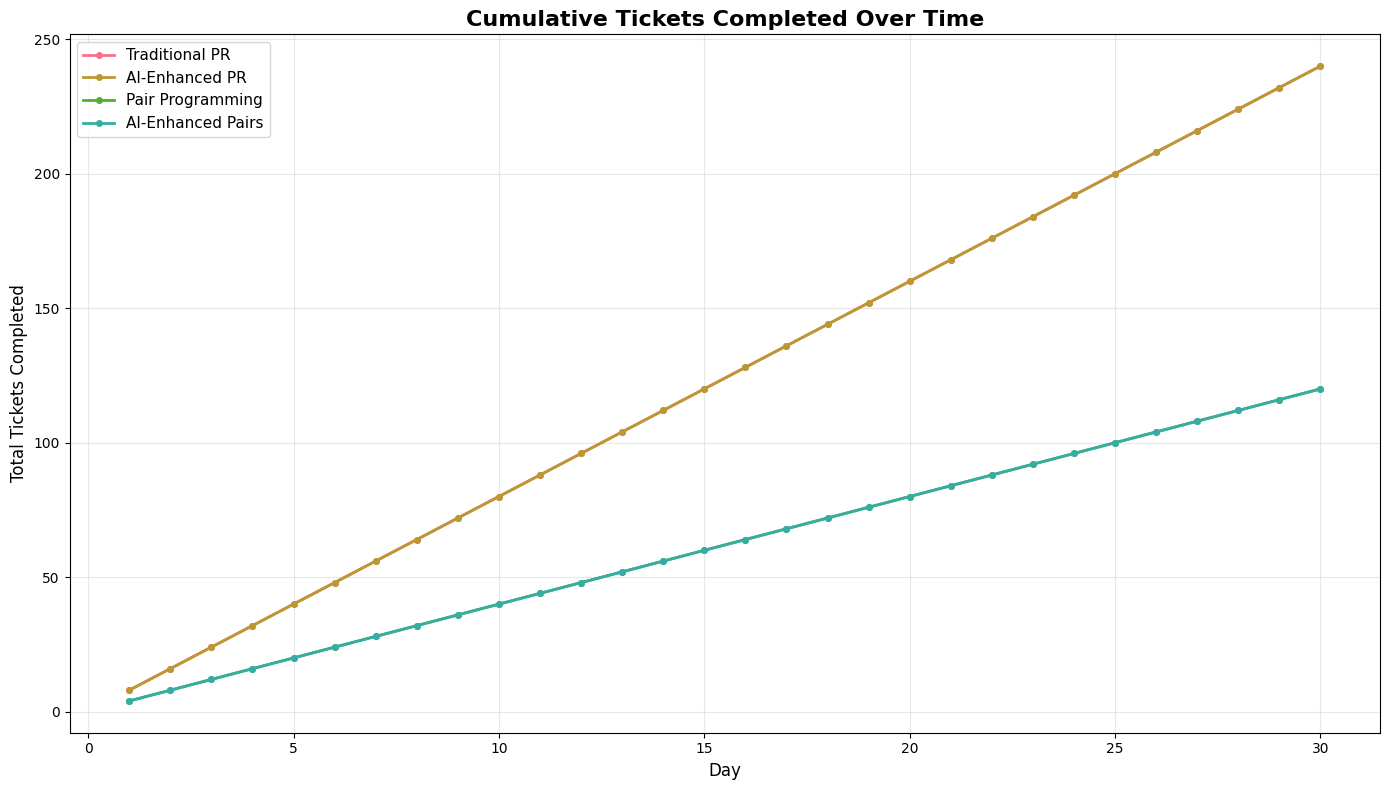

📊 Final Throughput Results (30 days):
  Traditional PR: 240 tickets (8.0/day)
  AI-Enhanced PR: 240 tickets (8.0/day)
  Pair Programming: 120 tickets (4.0/day)
  AI-Enhanced Pairs: 120 tickets (4.0/day)


In [8]:
# Visualization 1: Cumulative Throughput Over Time

plt.figure(figsize=(14, 8))

# Plot cumulative tickets completed over time
for scenario in daily_data['scenario'].unique():
    scenario_data = daily_data[daily_data['scenario'] == scenario]
    plt.plot(scenario_data['day'], scenario_data['total_tickets_completed'], 
             marker='o', linewidth=2, label=scenario, markersize=4)

plt.title('Cumulative Tickets Completed Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Tickets Completed', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show final numbers
final_day_data = daily_data[daily_data['day'] == daily_data['day'].max()]
print("📊 Final Throughput Results (30 days):")
for _, row in final_day_data.iterrows():
    print(f"  {row['scenario']}: {row['total_tickets_completed']} tickets ({row['cumulative_throughput']:.1f}/day)")

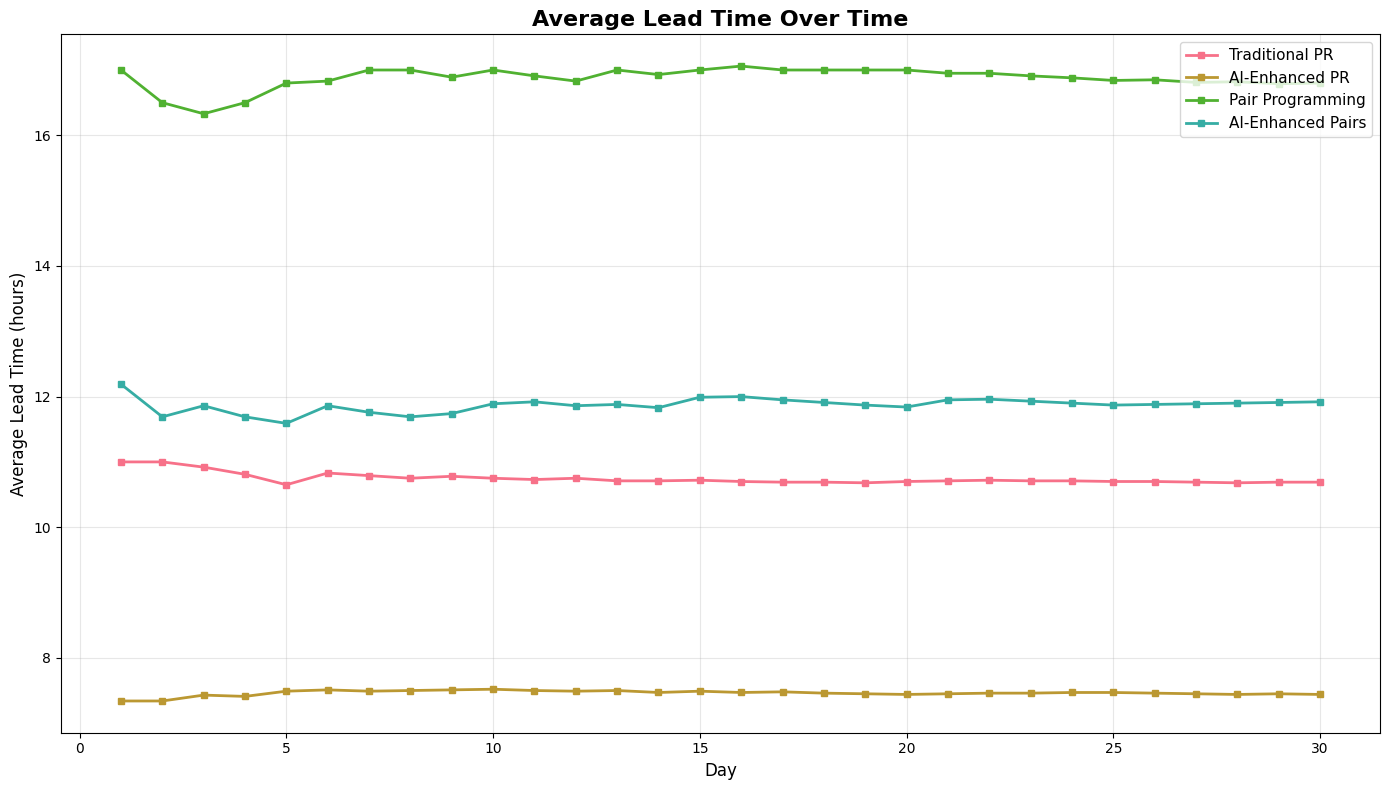

📊 Lead Time Summary:
         scenario  avg_lead_time_hours
   Traditional PR                10.69
   AI-Enhanced PR                 7.44
 Pair Programming                16.80
AI-Enhanced Pairs                11.92


In [9]:
# Visualization 2: Lead Time Comparison

plt.figure(figsize=(14, 8))

# Lead time over time
for scenario in daily_data['scenario'].unique():
    scenario_data = daily_data[daily_data['scenario'] == scenario]
    plt.plot(scenario_data['day'], scenario_data['avg_lead_time_hours'], 
             marker='s', linewidth=2, label=scenario, markersize=4)

plt.title('Average Lead Time Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Average Lead Time (hours)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("📊 Lead Time Summary:")
print(summary_data[['scenario', 'avg_lead_time_hours']].to_string(index=False))

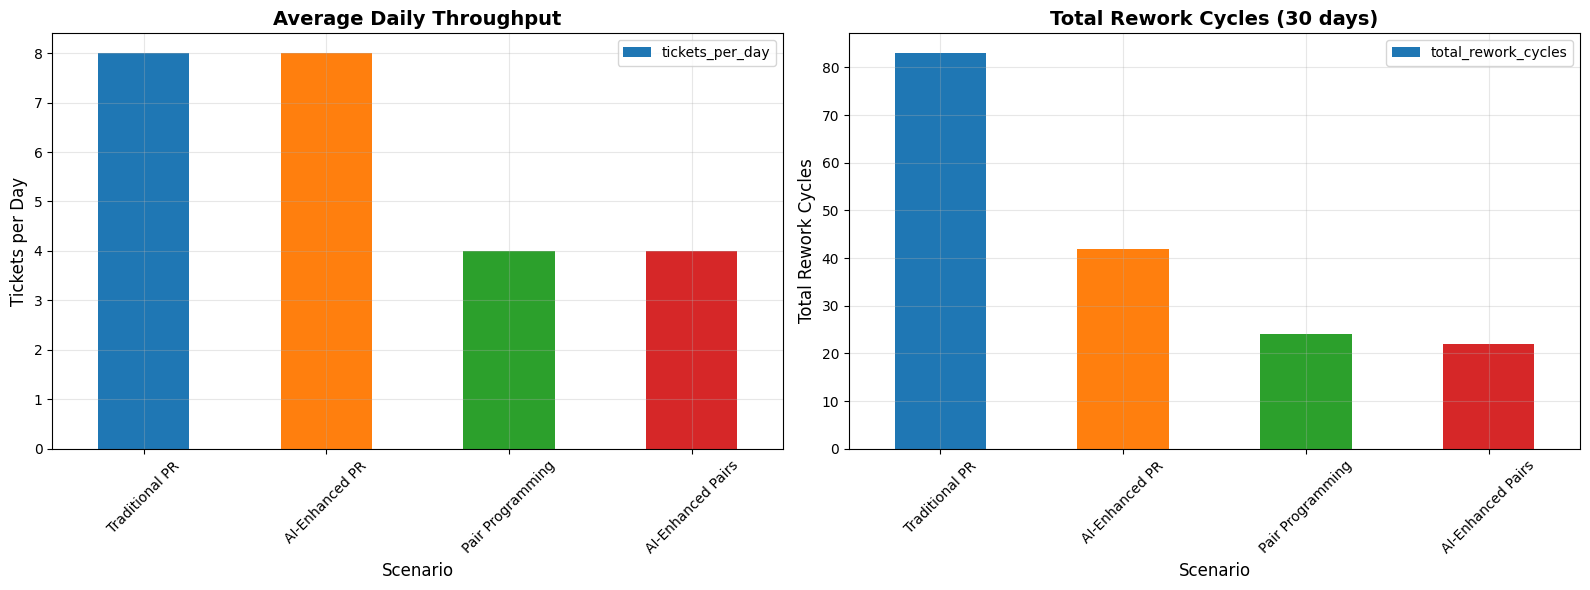


🚀 Productivity Improvements vs Traditional PR:
  AI-Enhanced PR: +0.0%
  Pair Programming: -50.0%
  AI-Enhanced Pairs: -50.0%


In [10]:
# Visualization 3: Daily Throughput Comparison

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Daily throughput bar chart
summary_data.plot(x='scenario', y='tickets_per_day', kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_title('Average Daily Throughput', fontsize=14, fontweight='bold')
ax1.set_ylabel('Tickets per Day', fontsize=12)
ax1.set_xlabel('Scenario', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Rework cycles comparison
summary_data.plot(x='scenario', y='total_rework_cycles', kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax2.set_title('Total Rework Cycles (30 days)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Total Rework Cycles', fontsize=12)
ax2.set_xlabel('Scenario', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate improvements
traditional_tpd = summary_data[summary_data['scenario'] == 'Traditional PR']['tickets_per_day'].iloc[0]
print("\n🚀 Productivity Improvements vs Traditional PR:")
for _, row in summary_data.iterrows():
    if row['scenario'] != 'Traditional PR':
        improvement = ((row['tickets_per_day'] / traditional_tpd - 1) * 100)
        print(f"  {row['scenario']}: {improvement:+.1f}%")

In [11]:
# Export Data for Further Analysis

# Save to CSV files
summary_data.to_csv('simulation_summary.csv', index=False)
daily_data.to_csv('simulation_daily_data.csv', index=False)

print("💾 Data exported to CSV files:")
print("  - simulation_summary.csv (summary metrics)")
print("  - simulation_daily_data.csv (daily time series data)")

# Display final summary table
print("\n📋 FINAL SUMMARY TABLE:")
print("=" * 80)
display_cols = ['scenario', 'tickets_per_day', 'avg_lead_time_hours', 'total_rework_cycles']
print(summary_data[display_cols].to_string(index=False))

print("\n✅ Clean data analysis complete!")
print("📊 You now have clean data ready for graphing and analysis")
print("📈 Time series data shows trends over 30 days")
print("🎯 All debug logs removed - pure data focus")

💾 Data exported to CSV files:
  - simulation_summary.csv (summary metrics)
  - simulation_daily_data.csv (daily time series data)

📋 FINAL SUMMARY TABLE:
         scenario  tickets_per_day  avg_lead_time_hours  total_rework_cycles
   Traditional PR              8.0                10.69                   83
   AI-Enhanced PR              8.0                 7.44                   42
 Pair Programming              4.0                16.80                   24
AI-Enhanced Pairs              4.0                11.92                   22

✅ Clean data analysis complete!
📊 You now have clean data ready for graphing and analysis
📈 Time series data shows trends over 30 days
🎯 All debug logs removed - pure data focus


In [ ]:
# Enhanced Visualization 4: Comprehensive Dashboard

fig = plt.figure(figsize=(20, 12))

# Create a 2x3 subplot layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Daily Throughput Trends
ax1 = fig.add_subplot(gs[0, :2])
for scenario in daily_data['scenario'].unique():
    scenario_data = daily_data[daily_data['scenario'] == scenario]
    ax1.plot(scenario_data['day'], scenario_data['tickets_completed_today'], 
             marker='o', linewidth=2, label=scenario, alpha=0.8)
ax1.set_title('Daily Throughput Trends', fontsize=14, fontweight='bold')
ax1.set_xlabel('Day')
ax1.set_ylabel('Tickets Completed Today')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Cumulative Performance
ax2 = fig.add_subplot(gs[0, 2])
final_totals = summary_data.set_index('scenario')['total_tickets']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
wedges, texts, autotexts = ax2.pie(final_totals.values, labels=final_totals.index, 
                                   autopct='%1.0f', colors=colors, startangle=90)
ax2.set_title('Total Tickets Share\n(30 days)', fontsize=12, fontweight='bold')

# 3. Lead Time Evolution
ax3 = fig.add_subplot(gs[1, :2])
for scenario in daily_data['scenario'].unique():
    scenario_data = daily_data[daily_data['scenario'] == scenario]
    # Use rolling average for smoother line
    rolling_lead_time = scenario_data['avg_lead_time_hours'].rolling(window=3, center=True).mean()
    ax3.plot(scenario_data['day'], rolling_lead_time, 
             linewidth=3, label=scenario, alpha=0.8)
ax3.set_title('Lead Time Evolution (3-day rolling average)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Day')
ax3.set_ylabel('Average Lead Time (hours)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Efficiency Metrics
ax4 = fig.add_subplot(gs[1, 2])
efficiency_data = summary_data.copy()
efficiency_data['efficiency'] = efficiency_data['tickets_per_day'] / efficiency_data['avg_lead_time_hours'] * 100
bars = ax4.bar(range(len(efficiency_data)), efficiency_data['efficiency'], 
               color=colors, alpha=0.7)
ax4.set_title('Efficiency Score\n(Tickets/Day per Lead Hour)', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(efficiency_data)))
ax4.set_xticklabels(efficiency_data['scenario'], rotation=45, ha='right')
ax4.set_ylabel('Efficiency Score')

# 5. Performance Comparison Matrix
ax5 = fig.add_subplot(gs[2, :])
metrics_matrix = summary_data[['scenario', 'tickets_per_day', 'avg_lead_time_hours', 'total_rework_cycles']].set_index('scenario')
# Normalize for heatmap (higher is better for tickets_per_day, lower is better for others)
normalized_matrix = metrics_matrix.copy()
normalized_matrix['tickets_per_day'] = normalized_matrix['tickets_per_day'] / normalized_matrix['tickets_per_day'].max()
normalized_matrix['avg_lead_time_hours'] = 1 - (normalized_matrix['avg_lead_time_hours'] / normalized_matrix['avg_lead_time_hours'].max())
normalized_matrix['total_rework_cycles'] = 1 - (normalized_matrix['total_rework_cycles'] / normalized_matrix['total_rework_cycles'].max())

im = ax5.imshow(normalized_matrix.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax5.set_xticks(range(len(normalized_matrix)))
ax5.set_xticklabels(normalized_matrix.index, rotation=45, ha='right')
ax5.set_yticks(range(len(normalized_matrix.columns)))
ax5.set_yticklabels(['Throughput', 'Lead Time', 'Rework Quality'])
ax5.set_title('Performance Heatmap (Green = Better)', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(normalized_matrix.columns)):
    for j in range(len(normalized_matrix)):
        original_value = metrics_matrix.iloc[j, i]
        text = ax5.text(j, i, f'{original_value:.1f}', 
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax5, shrink=0.6)
plt.suptitle('Queue Simulation Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)
plt.show()

print("📊 Comprehensive dashboard visualization complete!")

In [ ]:
# Enhanced Visualization 5: Scatter Plot Analysis

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Throughput vs Lead Time Scatter
for scenario in summary_data['scenario']:
    data = summary_data[summary_data['scenario'] == scenario]
    ax1.scatter(data['avg_lead_time_hours'], data['tickets_per_day'], 
               s=data['total_rework_cycles']*10, alpha=0.7, label=scenario)
    # Add text labels
    ax1.annotate(scenario, (data['avg_lead_time_hours'].iloc[0], data['tickets_per_day'].iloc[0]),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax1.set_xlabel('Average Lead Time (hours)')
ax1.set_ylabel('Tickets per Day')
ax1.set_title('Throughput vs Lead Time\n(Bubble size = Rework cycles)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Daily Variance Analysis
daily_pivot = daily_data.pivot(index='day', columns='scenario', values='tickets_completed_today')
ax2.boxplot([daily_pivot[col].dropna() for col in daily_pivot.columns], 
           labels=daily_pivot.columns)
ax2.set_title('Daily Throughput Distribution', fontweight='bold')
ax2.set_ylabel('Tickets Completed per Day')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display variance statistics
print("📊 Daily Throughput Statistics:")
print("="*50)
for scenario in daily_data['scenario'].unique():
    scenario_daily = daily_data[daily_data['scenario'] == scenario]['tickets_completed_today']
    print(f"{scenario}:")
    print(f"  Mean: {scenario_daily.mean():.2f} tickets/day")
    print(f"  Std Dev: {scenario_daily.std():.2f}")
    print(f"  Range: {scenario_daily.min()}-{scenario_daily.max()}")

In [ ]:
# Enhanced Visualization 6: Business Impact & ROI Analysis

# Calculate business metrics
business_data = summary_data.copy()

# Assumptions for business calculations
developer_cost_per_day = 500  # $500/day per developer
ticket_value = 1000  # $1000 value per completed ticket
ai_tool_cost_per_dev_per_day = 50  # $50/day AI tool cost

# Calculate costs and revenue
business_data['total_developers'] = [8, 8, 8, 8]  # All scenarios use 8 developers
business_data['daily_dev_cost'] = business_data['total_developers'] * developer_cost_per_day
business_data['ai_cost_per_day'] = [0, 8*ai_tool_cost_per_dev_per_day, 0, 8*ai_tool_cost_per_dev_per_day]
business_data['total_daily_cost'] = business_data['daily_dev_cost'] + business_data['ai_cost_per_day']
business_data['daily_revenue'] = business_data['tickets_per_day'] * ticket_value
business_data['daily_profit'] = business_data['daily_revenue'] - business_data['total_daily_cost']
business_data['roi_percent'] = (business_data['daily_profit'] / business_data['total_daily_cost']) * 100

# Create business visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Revenue vs Cost
x = range(len(business_data))
width = 0.35
ax1.bar([i - width/2 for i in x], business_data['daily_revenue'], width, 
        label='Daily Revenue', color='green', alpha=0.7)
ax1.bar([i + width/2 for i in x], business_data['total_daily_cost'], width, 
        label='Daily Cost', color='red', alpha=0.7)
ax1.set_title('Daily Revenue vs Cost', fontweight='bold')
ax1.set_ylabel('USD ($)')
ax1.set_xticks(x)
ax1.set_xticklabels(business_data['scenario'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Profit Analysis
colors = ['red' if profit < 0 else 'green' for profit in business_data['daily_profit']]
bars = ax2.bar(x, business_data['daily_profit'], color=colors, alpha=0.7)
ax2.set_title('Daily Profit by Scenario', fontweight='bold')
ax2.set_ylabel('Daily Profit ($)')
ax2.set_xticks(x)
ax2.set_xticklabels(business_data['scenario'], rotation=45, ha='right')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (100 if height > 0 else -200),
             f'${height:,.0f}', ha='center', va='bottom' if height > 0 else 'top')

# 3. ROI Comparison
ax3.bar(x, business_data['roi_percent'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
ax3.set_title('Return on Investment (ROI)', fontweight='bold')
ax3.set_ylabel('ROI (%)')
ax3.set_xticks(x)
ax3.set_xticklabels(business_data['scenario'], rotation=45, ha='right')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# 4. 30-Day Cumulative Impact
days_30 = 30
business_data['monthly_profit'] = business_data['daily_profit'] * days_30
business_data['monthly_tickets'] = business_data['tickets_per_day'] * days_30

# Cumulative profit over 30 days
ax4.bar(x, business_data['monthly_profit'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
ax4.set_title('30-Day Cumulative Profit', fontweight='bold')
ax4.set_ylabel('30-Day Profit ($)')
ax4.set_xticks(x)
ax4.set_xticklabels(business_data['scenario'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

# Add value labels
for i, profit in enumerate(business_data['monthly_profit']):
    ax4.text(i, profit + 1000, f'${profit:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print business analysis
print("💰 BUSINESS IMPACT ANALYSIS (30 days)")
print("="*60)
for i, row in business_data.iterrows():
    print(f"\n🔹 {row['scenario']}:")
    print(f"  Daily Revenue: ${row['daily_revenue']:,.0f}")
    print(f"  Daily Costs: ${row['total_daily_cost']:,.0f}")
    print(f"  Daily Profit: ${row['daily_profit']:,.0f}")
    print(f"  ROI: {row['roi_percent']:.1f}%")
    print(f"  30-Day Profit: ${row['monthly_profit']:,.0f}")
    print(f"  30-Day Tickets: {row['monthly_tickets']:.0f}")

# Calculate best ROI scenario
best_roi = business_data.loc[business_data['roi_percent'].idxmax()]
print(f"\n🏆 BEST ROI SCENARIO: {best_roi['scenario']}")
print(f"   ROI: {best_roi['roi_percent']:.1f}%")
print(f"   30-Day Profit: ${best_roi['monthly_profit']:,.0f}")

In [ ]:
# Final Summary Visualization: Executive Dashboard

# Create a comprehensive executive summary visualization
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.2)

# Key metrics cards
metrics = [
    ("Throughput Leader", summary_data.loc[summary_data['tickets_per_day'].idxmax(), 'scenario'], 
     f"{summary_data['tickets_per_day'].max():.1f} tickets/day"),
    ("Speed Leader", summary_data.loc[summary_data['avg_lead_time_hours'].idxmin(), 'scenario'], 
     f"{summary_data['avg_lead_time_hours'].min():.1f} hours"),
    ("Quality Leader", summary_data.loc[summary_data['total_rework_cycles'].idxmin(), 'scenario'], 
     f"{summary_data['total_rework_cycles'].min():.0f} rework cycles"),
    ("ROI Leader", business_data.loc[business_data['roi_percent'].idxmax(), 'scenario'], 
     f"{business_data['roi_percent'].max():.1f}% ROI")
]

for i, (title, winner, value) in enumerate(metrics):
    ax = fig.add_subplot(gs[0, i])
    ax.text(0.5, 0.7, title, ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(0.5, 0.4, winner, ha='center', va='center', fontsize=12, color='blue')
    ax.text(0.5, 0.1, value, ha='center', va='center', fontsize=11, color='green')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    # Add colored border
    rect = plt.Rectangle((0.05, 0.05), 0.9, 0.9, linewidth=3, 
                        edgecolor=['gold', 'silver', 'bronze', 'green'][i], 
                        facecolor='lightgray', alpha=0.3)
    ax.add_patch(rect)

# Bottom panel: Radar chart comparison
ax_radar = fig.add_subplot(gs[1, :])

# Prepare radar chart data
categories = ['Throughput', 'Speed\n(Inverse Lead Time)', 'Quality\n(Inverse Rework)', 'ROI']
scenarios = summary_data['scenario'].tolist()

# Normalize data for radar chart (0-100 scale)
radar_data = []
for _, row in summary_data.iterrows():
    # Normalize each metric to 0-100 scale
    throughput_norm = (row['tickets_per_day'] / summary_data['tickets_per_day'].max()) * 100
    speed_norm = (1 - (row['avg_lead_time_hours'] / summary_data['avg_lead_time_hours'].max())) * 100
    quality_norm = (1 - (row['total_rework_cycles'] / summary_data['total_rework_cycles'].max())) * 100
    roi_norm = (business_data.iloc[_]['roi_percent'] / business_data['roi_percent'].max()) * 100
    
    radar_data.append([throughput_norm, speed_norm, quality_norm, roi_norm])

# Create the radar chart manually using matplotlib
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Clear the axis and set up polar coordinates
ax_radar.clear()
ax_radar = plt.subplot(gs[1, :], projection='polar')

for i, (scenario, data) in enumerate(zip(scenarios, radar_data)):
    data += data[:1]  # Complete the circle
    ax_radar.plot(angles, data, 'o-', linewidth=2, label=scenario, color=colors[i])
    ax_radar.fill(angles, data, alpha=0.1, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories)
ax_radar.set_ylim(0, 100)
ax_radar.set_title('Performance Radar Chart\n(Higher = Better)', fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
ax_radar.grid(True)

plt.suptitle('Executive Summary Dashboard', fontsize=20, fontweight='bold', y=0.95)
plt.show()

# Print executive summary
print("🎯 EXECUTIVE SUMMARY")
print("="*60)
print(f"📊 Simulation Period: 30 days")
print(f"👥 Team Size: 8 developers across all scenarios")
print(f"💰 Assumptions: $500/dev/day, $1000/ticket, $50/day AI tools")

print(f"\n🏆 KEY FINDINGS:")
print(f"• Highest Throughput: {summary_data.loc[summary_data['tickets_per_day'].idxmax(), 'scenario']} ({summary_data['tickets_per_day'].max():.1f} tickets/day)")
print(f"• Fastest Delivery: {summary_data.loc[summary_data['avg_lead_time_hours'].idxmin(), 'scenario']} ({summary_data['avg_lead_time_hours'].min():.1f} hours)")
print(f"• Best Quality: {summary_data.loc[summary_data['total_rework_cycles'].idxmin(), 'scenario']} ({summary_data['total_rework_cycles'].min():.0f} rework cycles)")
print(f"• Best ROI: {business_data.loc[business_data['roi_percent'].idxmax(), 'scenario']} ({business_data['roi_percent'].max():.1f}% ROI)")

print(f"\n💡 RECOMMENDATIONS:")
ai_enhanced_pr = business_data[business_data['scenario'] == 'AI-Enhanced PR']
traditional_pr = business_data[business_data['scenario'] == 'Traditional PR']
if len(ai_enhanced_pr) > 0 and len(traditional_pr) > 0:
    roi_improvement = ai_enhanced_pr['roi_percent'].iloc[0] - traditional_pr['roi_percent'].iloc[0]
    profit_improvement = ai_enhanced_pr['monthly_profit'].iloc[0] - traditional_pr['monthly_profit'].iloc[0]
    print(f"• Implement AI tools: +{roi_improvement:.1f}% ROI improvement")
    print(f"• Expected 30-day profit increase: ${profit_improvement:,.0f}")

pair_programming = business_data[business_data['scenario'] == 'Pair Programming']
if len(pair_programming) > 0:
    print(f"• Consider pair programming for quality-critical projects")
    print(f"• Quality benefit: {summary_data.loc[summary_data['scenario'] == 'Pair Programming', 'total_rework_cycles'].iloc[0]:.0f} rework cycles vs {summary_data.loc[summary_data['scenario'] == 'Traditional PR', 'total_rework_cycles'].iloc[0]:.0f}")

print(f"\n✅ Analysis complete! All visualizations and data ready for presentation.")